In [1]:
import os.path as op

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from glob import glob
import nibabel as nib

In [4]:
path = '/Users/arokem/data/mri2mri/t1_pdd_cosine_L1_unet128_T3_3d/'

In [5]:
real_a_files = glob(op.join(path, 'IXI029*real_A*'))
real_b_files = glob(op.join(path, 'IXI029*real_B*'))
fake_b_files = glob(op.join(path, 'IXI029*fake_B*'))

In [6]:
real_a_files.sort()
real_b_files.sort()
fake_b_files.sort()

In [7]:
real_a = np.zeros((len(real_a_files), 128, 128, 3))
real_b = np.zeros((len(real_a_files), 128, 128, 3))
fake_b = np.zeros((len(real_a_files), 128, 128, 3))
for ii in range(len(real_a_files)):
    real_a[ii]= np.load(real_a_files[ii]) 
    real_b[ii]= np.load(real_b_files[ii]) 
    fake_b[ii]= np.load(fake_b_files[ii])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


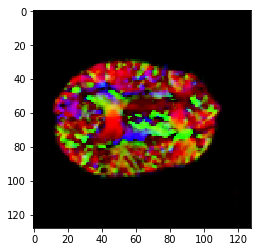

In [8]:
plt.imshow(fake_b[27])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


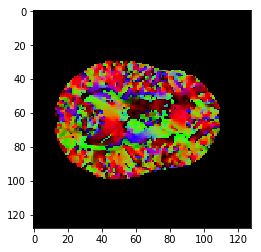

In [45]:
plt.imshow(real_b[27])

In [9]:
from dipy.reconst import dti
from dipy.tracking.eudx import EuDX
from dipy.data import get_sphere

In [10]:
odf_vertices = get_sphere('symmetric362').vertices

In [11]:
def pdd_to_ind(pdd, odf_vertices):
    tup = pdd.shape[:-1]
    mec = pdd.reshape(np.prod(np.array(tup)), 3)
    ind = np.array([np.argmin(np.dot(odf_vertices, m)) for m in mec])
    ind = ind.reshape(tup)
    ind = np.moveaxis(ind, 0, -1)
    return ind

In [12]:
real_ind = pdd_to_ind(real_b, odf_vertices)
fake_ind = pdd_to_ind(fake_b, odf_vertices)

In [13]:
data = np.array([nib.load('/Users/arokem/data/mri2mri/IXI029-Guys-0829-DTI-%02d.nii.gz'%ii).get_data() for ii in range(16)])

In [14]:
data = np.moveaxis(data, 0, -1)

In [15]:
data = data[:, :, 1:-1]

In [16]:
data.shape

(128, 128, 54, 16)

In [17]:
import dipy.core.gradients as dpg

In [18]:
gtab = dpg.gradient_table('/Users/arokem/data/mri2mri/bvals.txt', '/Users/arokem/data/mri2mri/bvecs.txt')

In [19]:
from dipy.segment.mask import median_otsu
b0_mask, mask = median_otsu(data, 2, 1)

In [20]:
model = dti.TensorModel(gtab)

In [21]:
fit = model.fit(data, mask=mask)

In [22]:
FA = fit.fa

In [23]:
eu_fake = EuDX(a=FA, ind=fake_ind, seeds=1000000, odf_vertices=odf_vertices, a_low=0.1)
streamlines_fake = [e for e in eu_fake if e.shape[0]>20]

In [24]:
eu_real = EuDX(a=FA, ind=real_ind, seeds=1000000, odf_vertices=odf_vertices, a_low=0.1)
streamlines_real = [e for e in eu_real if e.shape[0]>20]

In [25]:
# for streamlines, out_path in zip([streamlines_fake, streamlines_real], ["fake", "real"]):
#     from dipy.viz import window, actor
#     from dipy.viz.colormap import line_colors

#     r = window.Renderer()
#     streamlines_actor = actor.line(streamlines)

#     r.add(streamlines_actor)
#     window.record(r, out_path=out_path, path_numbering=True, n_frames=36, size=(800, 800))

In [26]:
len(streamlines_fake)

122935

In [27]:
len(streamlines_real)

126356

In [28]:
import dipy.io as dio

In [29]:
import dipy.tracking.utils as dtu
from nibabel import trackvis

def write_trk(fname, streamlines, affine=None, shape=None):
    """
    Write out a .trk file

    Parameters
    ----------
    fname : str
        Full path to save the file into
    streamlines : list
        A list of arrays of 3D coordinates
    affine : array (4,4), optional.
        An affine transformation associated with the streamlines. Defaults to
        identity.
    shape : 3-element tuple, optional
        Spatial dimensions of an image associated with the streamlines.
        Defaults to not be set in the file header.
    """
    if affine is None:
        affine = np.eye(4)

    zooms = np.sqrt((affine * affine).sum(0))
    streamlines = dtu.move_streamlines(streamlines, affine)
    data = ((s, None, None) for s in streamlines)

    voxel_order = nib.orientations.aff2axcodes(affine)
    voxel_order = "".join(voxel_order)

    hdr = nib.trackvis.empty_header()
    hdr['voxel_size'] = zooms[:3]
    hdr['voxel_order'] = voxel_order
    hdr['vox_to_ras'] = affine
    if shape is not None:
        hdr['dim'] = shape
    trackvis.write(fname, data, hdr, points_space="rasmm")


In [30]:
aff = nib.load('/Users/arokem/data/mri2mri/IXI029-Guys-0829-DTI-00.nii.gz').affine

In [31]:
write_trk('real.trk', streamlines_real, affine=aff)

In [32]:
write_trk('fake.trk', streamlines_fake, affine=aff)

In [36]:
meanV1_img = nib.load('/Users/arokem/data/mri2mri/IIT-templates/IITmedian_V1.nii.gz')

In [37]:
meanV1 = meanV1_img.get_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


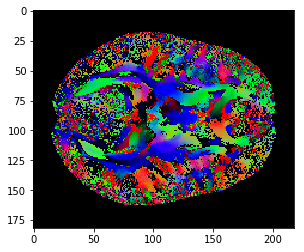

In [44]:
plt.imshow(meanV1[:, :, 80])

In [47]:
meant1_img = nib.load('/Users/arokem/data/mri2mri/IIT-templates/IITmean_t1.nii.gz')

In [48]:
meant1 = meant1_img.get_data()

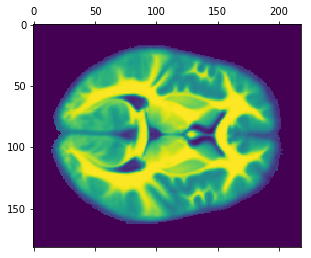

In [49]:
plt.matshow(meant1[:, :, 80])